In [1]:
from PIL import Image
from pillow_heif import register_heif_opener
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import time
import random
from functools import reduce
import operator

torch.manual_seed(112916)

register_heif_opener()

image = Image.open('data/IMG_1432.HEIC')

print(image.size)
print(image.mode)

(1018, 240)
RGB


In [2]:
DEVICE = 'mps'

transform = transforms.Compose([ 
    transforms.PILToTensor() 
])

img_tensor = transform(image)
img_tensor = img_tensor.to(torch.float) / 255.0

print(img_tensor.shape)

torch.Size([3, 240, 1018])


In [3]:
IMAGE_CHANNELS = 3
SLICES = 31

# calculate slice width
slice_width = img_tensor.shape[2] // SLICES
slice_height = img_tensor.shape[1]
slice_shape = (IMAGE_CHANNELS, slice_height, slice_width)
# note that we are no longer flattening the slices because our 2D inputs will go
# to a conv layer

hidden_size = 512
latent_size = 256
conv_1_out = 32
conv_2_out = 64
conv_3_out = 128

slice_hw_ratio = slice_height//slice_width

print(f'Slice Shape: {slice_shape}')
print(f'Slice H/W Ratio: {slice_hw_ratio}')

Slice Shape: (3, 240, 32)
Slice H/W Ratio: 7


In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def visualize_feature_maps(layer_output, num_feature_maps=5, cols=5):
    """
    Visualizes feature maps from a given layer output.

    Args:
    - layer_output (torch.Tensor): The output tensor from the layer you wish to visualize.
                                   Shape should be [N, C, H, W] (batch size, number of channels, height, width).
    - num_feature_maps (int): Number of feature maps to visualize. Default is 10.
    - cols (int): Number of columns in the subplot grid. Default is 5.
    """
    # Ensure layer_output is on CPU and detached from the computation graph
    feature_maps = layer_output[0].detach().cpu()

    # Determine the number of rows needed in the subplot grid
    rows = num_feature_maps // cols + int(num_feature_maps % cols != 0)

    # Set up the figure size and grid for plots
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows * 2.5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate and plot each feature map
    for i in range(num_feature_maps):
        if i < feature_maps.shape[0]:  # Check if the index is within the number of available feature maps
            # Access the feature map for the ith filter and convert to numpy
            feature_map = feature_maps[i].numpy()
            axes[i].imshow(feature_map, cmap='gray', aspect='auto')
            axes[i].axis('off')
            # axes[i].set_title(f'Feature Map {i+1}')
        else:
            axes[i].axis('off')  # Turn off axis for any unused subplot

    plt.tight_layout()
    plt.show()

In [5]:
# encoder portion. will take our slices and (learn to) encode them into the latent space
class TripleConvResidual(nn.Module):
    """ Performs three convolutions with a skip connection """
    def __init__(self, in_dims, out_channels, kernel_size, res=True):
        super(TripleConvResidual, self).__init__()
        
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.in_dims = in_dims
        self.in_channels = in_dims[0]
        self.out_dims = (out_channels, in_dims[1], in_dims[2])
        self.res = res

        if res and in_dims[0] != out_channels:
            self.resample = nn.Sequential(
                nn.Conv2d(in_dims[0], out_channels, kernel_size=1, stride=1, bias=False),
                nn.LayerNorm([out_channels, in_dims[1], in_dims[2]])
            )
        else:
            self.resample = nn.Identity()
        
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                               stride=1, padding=self.padding)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, 
                               stride=1, padding=self.padding)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, 
                               stride=1, padding=self.padding)
        self.relu = nn.LeakyReLU(0.2)
        self.ln = nn.LayerNorm([out_channels, in_dims[1], in_dims[2]])
    
    def forward(self, x):
        res_mix = self.resample(x)
        
        x = self.conv1(x)
        #print(f'conv1 out shape: {x.shape}')
        x = self.conv2(x)
        #print(f'conv2 out shape: {x.shape}')
        x = self.ln(self.conv3(x))

        if self.res:
            x = x + res_mix

        x = self.relu(x)
        #print(f'conv3 out shape: {x.shape}')

        return x
        

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.deep_conv1 = TripleConvResidual(slice_shape, conv_1_out, 3)
        self.deep_conv2 = TripleConvResidual(self.deep_conv1.out_dims, conv_2_out, 3)
        self.deep_conv3 = TripleConvResidual(self.deep_conv2.out_dims, conv_3_out, 3)
        self.conv_dims = [self.deep_conv1.out_dims, self.deep_conv2.out_dims, 
                          self.deep_conv3.out_dims]
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.pooled_dims = (self.deep_conv3.out_dims[0], 
            ((self.deep_conv3.out_dims[1] - 3) // 2) + 1,
            ((self.deep_conv3.out_dims[2] - 3) // 2) + 1)
        self.flatten = nn.Flatten()
        self.flat_dims = reduce(operator.mul, self.pooled_dims)
        #print('flat dims', self.flat_dims)
        self.relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(self.flat_dims, hidden_size)
        self.norm1 = nn.LayerNorm([self.flat_dims])
        self.norm2 = nn.LayerNorm([hidden_size])
        self.mean = nn.Linear(hidden_size, latent_size)
        self.var = nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):
        x = self.deep_conv1(x)
        # visualize_feature_maps(x)
        x = self.deep_conv2(x)
        x = self.deep_conv3(x)
        # visualize_feature_maps(x)
        x = self.pool1(x)
        x = self.flatten(x)
        #print('flatten', x.shape)
        x = self.relu(self.norm1(x))
        x = self.relu(self.norm2(self.linear1(x)))
        
        mean = self.mean(x)
        log_variance = self.var(x)
        
        return mean, log_variance


class UpsampleAndConv(nn.Module):
    def __init__(self, scale_factor, in_channels, out_channels, kernel_size, stride, padding, mode='nearest'):
        super(UpsampleAndConv, self).__init__()
        self.scale_factor = scale_factor
        self.refine_conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding+1)
        self.refine_conv2 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding)
        self.refine_conv3 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mode = mode

    def forward(self, x):
        x_upsampled = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode,
                                    align_corners=True if self.mode == 'bilinear' else None)
        #print('x_upsampled shape', x_upsampled.shape)
        x = self.refine_conv1(x_upsampled)
        #print('refine_conv1 shape', x.shape)
        x = self.refine_conv2(x)
        #print('refine_conv2 shape', x.shape)
        x = self.refine_conv3(x)
        #print('refine_conv3 shape', x.shape)
        return x



# decoder portion. takes data that is normally distributed in the latent space
# and decodes to the input space
class Decoder(nn.Module):
    def __init__(self, encoder_conv_out_dims, encoder_flat_dims, encoder_pooled_dims):
        super(Decoder, self).__init__()

        self.latent_in = nn.Linear(latent_size, hidden_size)
        self.hidden_layer1 = nn.Linear(hidden_size, encoder_flat_dims)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=encoder_pooled_dims)
        self.unpool = UpsampleAndConv(mode='nearest', scale_factor=2, 
                                      in_channels=encoder_conv_out_dims[2][0], 
                                      out_channels=encoder_conv_out_dims[1][0], 
                                      kernel_size=3, stride=1, padding=1)
        self.unconv2 = TripleConvResidual(encoder_conv_out_dims[1], encoder_conv_out_dims[0][0], 3)
        self.unconv1 = TripleConvResidual(encoder_conv_out_dims[0], IMAGE_CHANNELS, 3)
        
        self.norm1 = nn.LayerNorm([hidden_size])
        self.norm2 = nn.LayerNorm([encoder_flat_dims])
        
        self.relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.norm1(self.latent_in(x)))
        x = self.relu(self.norm2(self.hidden_layer1(x)))
        x = self.unflatten(x)
        x = self.unpool(x)
        #visualize_feature_maps(x)
        #print(f'unpool shape: {x.shape}')
        x = self.unconv2(x)
        # visualize_feature_maps(x)
        #print(f'uc2 shape: {x.shape}')
        x = self.unconv1(x)
        #print(f'uc1 shape: {x.shape}')
        x = self.sigmoid(x)
        
        return x
    
# puts it all together and adds the reparameterization trick to 
# establish the Gaussian distribution
class VAETrainingModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAETrainingModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def reparameterize(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        return mean + epsilon * var
        
    def forward(self, x):
        mean, log_var = self.encoder(x)
        x = self.reparameterize(mean, log_var)
        x = self.decoder(x)
        
        return x, mean, log_var
    
def cost_function(x, x_pred, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_pred, x)
    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [6]:
BATCH_SIZE = 15
EPOCH_ITERS = img_tensor.shape[2] // slice_width // BATCH_SIZE
MODEL_WEIGHTS_FILE = 'out/model_conv.pt'

# train the model on the flattened data
def train_model(model, next_batch, criterion, optimizer, scheduler, num_epochs=25):
    print(f'Model is training with {num_epochs} epochs with {EPOCH_ITERS} iterations per epoch')
    since = time.time()

    best_loss = np.inf
    best_epoch = 0

    phases = ['train', 'val']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # iterate over enough batches to try to cover the entire image (1 epoch)
            for _ in range(EPOCH_ITERS):
                inputs = next_batch(BATCH_SIZE)
                # print('Batch is', inputs.shape[0])
                inputs = inputs.to(DEVICE)
                # our targets are the same as our inputs
                targets = inputs.to(DEVICE)
                # print(inputs.shape)
                # print(targets.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    x_pred, mean, log_var = model(inputs)
                    # print(outputs.shape)
                    loss = criterion(targets, x_pred, mean, log_var)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if scheduler and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / BATCH_SIZE
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # save the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              with open(MODEL_WEIGHTS_FILE, 'wb') as f:
                torch.save(model.state_dict(), f)

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(torch.load(MODEL_WEIGHTS_FILE, map_location=DEVICE))

    return model, training_curves

In [7]:
LEARNING_RATE = 3e-4

encoder = Encoder().to(DEVICE)
print('Encoder: ', sum(p.numel() for p in encoder.parameters())/1e6, 'M parameters')
decoder = Decoder(encoder_conv_out_dims=encoder.conv_dims, 
                  encoder_flat_dims=encoder.flat_dims,
                  encoder_pooled_dims=encoder.pooled_dims).to(DEVICE)
print('Decoder: ', sum(p.numel() for p in decoder.parameters())/1e6, 'M parameters')
training_model = VAETrainingModel(encoder, decoder).to(DEVICE)

optimizer_ = torch.optim.AdamW(training_model.parameters(), lr=LEARNING_RATE)
scheduler_ = torch.optim.lr_scheduler.ExponentialLR(optimizer_, gamma=0.95)

Encoder:  125.075296 M parameters
Decoder:  118.744363 M parameters


In [8]:
def get_batch(batch_size):
    """ Returns a batch consisting of batch_size slices of the training data """
    # our img_tensor is torch.Size([3, 1917, 8141])
    # so we want to start at a random spot in the tensor that is < slice_width
    # then take a slice_width chunk of the 3rd dimension which is the width
    
    # calculate the maximum start index for the width
    max_start_index_width = img_tensor.size(2) - slice_width

    batch_list = []
    for _ in range(batch_size):
        start = random.randint(0, max_start_index_width)
        img_slice = img_tensor[:, :, start:start + slice_width]
        #print(f'Random tensor of size {img_slice.shape} width at {start} ')
        batch_list.append(img_slice)
        
    ret = torch.stack(batch_list)
    #print(ret.shape)
    return ret

In [9]:
EPOCHS = 180
#train_model(training_model, get_batch, cost_function, optimizer_, scheduler_, EPOCHS)
train_model(training_model, get_batch, cost_function, optimizer_, None, EPOCHS)

Model is training with 180 epochs with 2 iterations per epoch

Epoch 1/180
----------
train Loss: 929.9973
val   Loss: 592.6615

Epoch 2/180
----------
train Loss: 471.0710
val   Loss: 223.0898

Epoch 3/180
----------
train Loss: 170.3698
val   Loss: 71.4740

Epoch 4/180
----------
train Loss: 63.0910
val   Loss: 50.2812

Epoch 5/180
----------
train Loss: 50.3175
val   Loss: 51.5586

Epoch 6/180
----------
train Loss: 52.2698
val   Loss: 53.8366

Epoch 7/180
----------
train Loss: 53.2902
val   Loss: 51.2453

Epoch 8/180
----------
train Loss: 49.2816
val   Loss: 42.3071

Epoch 9/180
----------
train Loss: 39.5806
val   Loss: 31.1844

Epoch 10/180
----------
train Loss: 28.7019
val   Loss: 21.4146

Epoch 11/180
----------
train Loss: 19.7223
val   Loss: 15.3268

Epoch 12/180
----------
train Loss: 14.3995
val   Loss: 12.1390

Epoch 13/180
----------
train Loss: 11.7299
val   Loss: 10.5061

Epoch 14/180
----------
train Loss: 10.0868
val   Loss: 9.2044

Epoch 15/180
----------
train Lo

(VAETrainingModel(
   (encoder): Encoder(
     (deep_conv1): TripleConvResidual(
       (resample): Sequential(
         (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1): LayerNorm((32, 240, 32), eps=1e-05, elementwise_affine=True)
       )
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): LeakyReLU(negative_slope=0.2)
       (ln): LayerNorm((32, 240, 32), eps=1e-05, elementwise_affine=True)
     )
     (deep_conv2): TripleConvResidual(
       (resample): Sequential(
         (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1): LayerNorm((64, 240, 32), eps=1e-05, elementwise_affine=True)
       )
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (conv2): Conv2d(64, 64, kernel_size=(3,

In [10]:
import math
# sample images from the latent space
import matplotlib.pyplot as plt
from matplotlib import gridspec

def stitch_and_show_images(x):
    """
    Stitch image slices horizontally and show the resulting single image.

    :param x: Tensor containing the image slices.
    :param slice_shape: Shape of each slice (channels, height, width).
    """
    x = x.view(-1, *slice_shape)  # Reshape
    x = x.permute(0, 2, 3, 1)     # Reorder dimensions for plotting

    # Concatenate all slices horizontally
    stitched_image = torch.cat(tuple(x), dim=1)
    
    # Calculate the full size for displaying
    full_width = stitched_image.shape[1]
    full_height = stitched_image.shape[0]
    dpi = 80  # Adjust dpi to your screen for accurate sizing (default is usually 80 or 100)
    figsize = full_width / dpi, full_height / dpi
    
    # Convert to numpy and plot
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(stitched_image.cpu().numpy())
    plt.axis('off')
    plt.show()

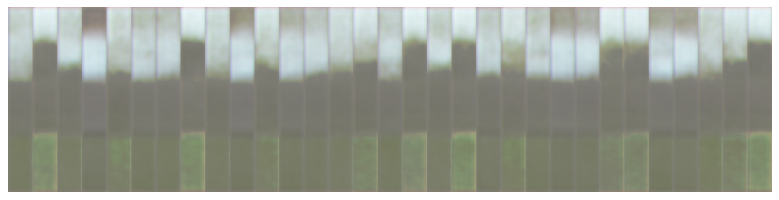

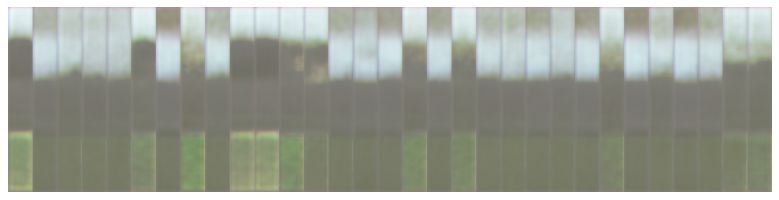

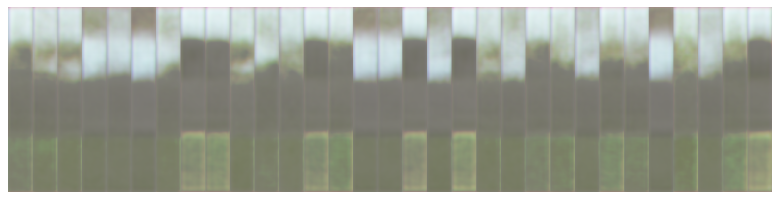

In [11]:
for _ in range(3):
    with torch.no_grad():
        noise = torch.randn(SLICES, latent_size).to(DEVICE)
        generated_images = training_model.decoder(noise)
        stitch_and_show_images(generated_images)    